## Задание  
Обучить СНС с помощью Transfer Learning на датасете Food-101  
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.  
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета Food-101

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    name="food101", # target dataset to get from TFDS
    split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
    shuffle_files=True, # shuffle files on download?
    as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
    with_info=True
) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [3]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [4]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [5]:
# Take one sample off the training data
train_one_sample = train_ds.take(1) # samples are in format (image_tensor, label)

In [6]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image dtype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 43
    Class name (str form): fried_calamari
    


In [ ]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

## Визуализация датасета Food-101

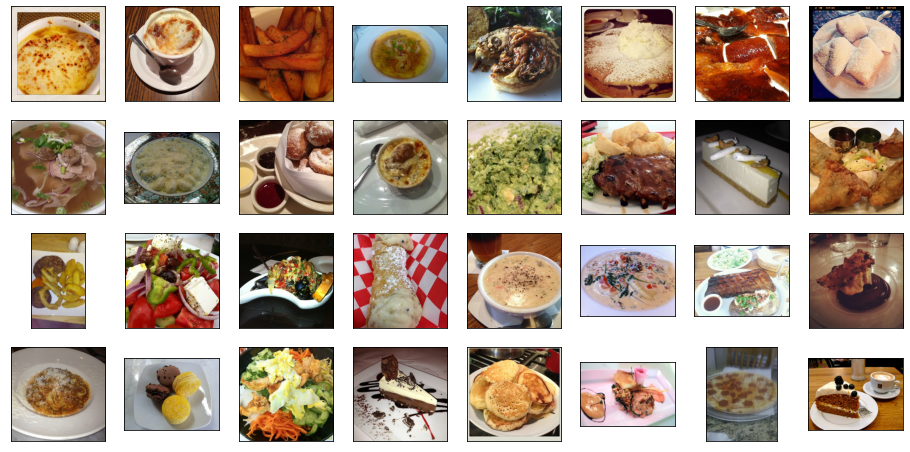

In [7]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [8]:
INP_SIZE = 160
NUM_EPOCHS = 3
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

## Подготовка модели CNN

In [9]:
EXP_NAME = 'transfer'
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True # Fine-tuning весов предобученной модели
#base_model.trainable = False # Заморозка весов предобученной модели

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax'),
])

## Подготовка к обучению

In [10]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

## Model Summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


## Обучение модели

In [12]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/3
2367/2367 [==============================] - 4742s 2s/step - loss: 2.0667 - accuracy: 0.4948 - val_loss: 1.3708 - val_accuracy: 0.6299
Epoch 2/3
2367/2367 [==============================] - 4776s 2s/step - loss: 1.1937 - accuracy: 0.6857 - val_loss: 1.2511 - val_accuracy: 0.6649
Epoch 3/3
2367/2367 [==============================] - 4798s 2s/step - loss: 0.8667 - accuracy: 0.7651 - val_loss: 1.1203 - val_accuracy: 0.7005
CPU times: total: 20h 14min 8s
Wall time: 3h 58min 35s


## Оценка качества модели

In [13]:
%%time

model.evaluate(test_ds)

197/197 [==============================] - 307s 2s/step - loss: 1.1198 - accuracy: 0.7006
CPU times: total: 25min 38s
Wall time: 5min 6s


[1.119802474975586, 0.7005869150161743]

## Инференс и отображение результата предсказания

In [30]:
import random

In [31]:
def test_item(sample):
    
    fig = plt.figure(figsize=(12,4))

    img = tf.cast((sample + 1)*127, tf.uint8)

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(img)
    plt.xticks([]), plt.yticks([])

    prediction = model(sample[None, ...])[0]
    ans = np.argmax(prediction)
    
    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(101), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(101))
    ax.set_xlim([-1, 101])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(ds_info.features['label'].int2str(ans)))

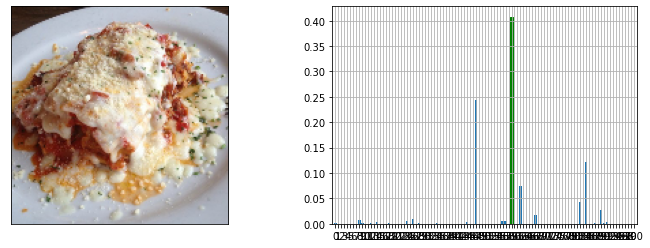

Predicted: lasagna
True Answer: lasagna


In [32]:
rand_batch = random.randint(0, len(test_ds)-1)
rand_idx = random.randint(0, 128)
sample_batch = iter(test_ds.skip(rand_batch).take(1)).get_next()

test_item(sample_batch[0][rand_idx])

print('True Answer: {}'.format(ds_info.features['label'].int2str(sample_batch[1][rand_idx].numpy())))